# Compare samplers

In this notebook, we'll compare the different samplers implemented in `tupak`. As of this version, we don't compare the outputs, only how to run them and the timings for their default setup.

## Setup

In [1]:
import numpy as np
import pylab as plt

%load_ext autoreload
%autoreload 2

import tupak

tupak.utils.setup_logger()

time_duration = 1.
sampling_frequency = 4096.

injection_parameters = dict(mass_1=36., mass_2=29., a_1=0, a_2=0, tilt_1=0, tilt_2=0, phi_12=0, phi_jl=0,
                            luminosity_distance=100., iota=0.4, phase=1.3, waveform_approximant='IMRPhenomPv2',
                            reference_frequency=50., ra=1.375, dec=-1.2108, geocent_time=1126259642.413,
                            psi=2.659)

waveform_generator = tupak.waveform_generator.WaveformGenerator(
    sampling_frequency=sampling_frequency,
    time_duration=time_duration,
    frequency_domain_source_model=tupak.source.lal_binary_black_hole,
    parameters=injection_parameters)

hf_signal = waveform_generator.frequency_domain_strain()

H1 = tupak.detector.get_empty_interferometer('H1')
H1.set_data(sampling_frequency=sampling_frequency, duration=time_duration,
            from_power_spectral_density=True)
H1.inject_signal(waveform_polarizations=hf_signal, parameters=injection_parameters)

IFOs = [H1]

likelihood = tupak.likelihood.GravitationalWaveTransient(IFOs, waveform_generator)

11:28 INFO    : Running tupak version: (UNCLEAN) 5a8eda6 2018-05-17 19:56:51 -0500

11:28 INFO    : Setting H1 data using noise realization from providedpower_spectal_density
11:28 INFO    : Injection found with optimal SNR = 223.94 and matched filter SNR = 224.47 in H1


## Prior

For this test, we will simply search of the sky position, setting the other parameters to their simulated values.

In [2]:
priors = tupak.prior.parse_floats_to_fixed_priors(injection_parameters)
priors['ra'] = tupak.prior.Uniform(0, 2*np.pi, 'ra')
priors['dec'] = tupak.prior.Uniform(-np.pi/2, np.pi/2, 'dec')

11:28 INFO    : Expected parameter waveform_approximant to be a float or int but was <type 'str'> instead. Will not be converted.


## PyMultinest

11:28 INFO    : waveform_approximant cannot be converted to delta function prior.
11:28 INFO    : Writing priors to outdir/prior.txt
11:28 INFO    : Search parameters:
11:28 INFO    :   ra ~ Uniform(support=6.28318530718, minimum=0, name=ra, maximum=6.28318530718, _Prior__latex_label=$\mathrm{RA}$)
11:28 INFO    :   dec ~ Uniform(support=3.14159265359, minimum=-1.57079632679, name=dec, maximum=1.57079632679, _Prior__latex_label=$\mathrm{DEC}$)
11:28 INFO    :   psi = 2.659
11:28 INFO    :   a_2 = 0
11:28 INFO    :   a_1 = 0
11:28 INFO    :   geocent_time = 1126259642.41
11:28 INFO    :   reference_frequency = 50.0
11:28 INFO    :   phi_jl = 0
11:28 INFO    :   phase = 1.3
11:28 INFO    :   mass_2 = 29.0
11:28 INFO    :   mass_1 = 36.0
11:28 INFO    :   phi_12 = 0
11:28 INFO    :   luminosity_distance = 100.0
11:28 INFO    :   tilt_2 = 0
11:28 INFO    :   iota = 0.4
11:28 INFO    :   tilt_1 = 0
11:28 WARNING : Cannot sample from waveform_approximant, 'str' object has no attribute 'sampl

  analysing data from outdir/pymultinest_pymultinest/.txt


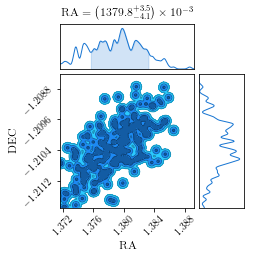

nsamples: 218
noise_logz: -27253.938
logz: -1954.211 +/-  0.256
log_bayes_factor: 25299.727 +/-  0.256

CPU times: user 15.8 s, sys: 1.41 s, total: 17.2 s
Wall time: 16.9 s


In [3]:
%%time 
result = tupak.sampler.run_sampler(
    likelihood, priors=priors, sampler='pymultinest', label='pymultinest',
    npoints=200, verbose=False, resume=False)
fig = result.plot_corner(save=False)
plt.show()
print(result)

# dynesty

11:29 INFO    : waveform_approximant cannot be converted to delta function prior.
11:29 INFO    : Writing priors to outdir/prior.txt
11:29 INFO    : Search parameters:
11:29 INFO    :   ra ~ Uniform(support=6.28318530718, minimum=0, name=ra, maximum=6.28318530718, _Prior__latex_label=$\mathrm{RA}$)
11:29 INFO    :   dec ~ Uniform(support=3.14159265359, minimum=-1.57079632679, name=dec, maximum=1.57079632679, _Prior__latex_label=$\mathrm{DEC}$)
11:29 INFO    :   psi = 2.659
11:29 INFO    :   a_2 = 0
11:29 INFO    :   a_1 = 0
11:29 INFO    :   geocent_time = 1126259642.41
11:29 INFO    :   reference_frequency = 50.0
11:29 INFO    :   phi_jl = 0
11:29 INFO    :   phase = 1.3
11:29 INFO    :   mass_2 = 29.0
11:29 INFO    :   mass_1 = 36.0
11:29 INFO    :   phi_12 = 0
11:29 INFO    :   luminosity_distance = 100.0
11:29 INFO    :   tilt_2 = 0
11:29 INFO    :   iota = 0.4
11:29 INFO    :   tilt_1 = 0
11:29 WARNING : Cannot sample from waveform_approximant, 'str' object has no attribute 'sampl

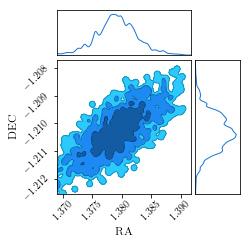

nsamples: 3529
noise_logz: -27253.938
logz: -1954.279 +/-  0.257
log_bayes_factor: 25299.660 +/-  0.257

CPU times: user 50 s, sys: 8.41 s, total: 58.5 s
Wall time: 47.3 s


In [ ]:
%%time 
result = tupak.sampler.run_sampler(
    likelihood, priors=priors, sampler='dynesty', label='dynesty',
    bound='multi', sample='rwalk', npoints=200, walks=1, verbose=False,
    update_interval=100)
fig = result.plot_corner(save=False)
plt.show()
print(result)

# Dynamic Nested Sampling (Dynesty)

See [the dynesty docs](http://dynesty.readthedocs.io/en/latest/dynamic.html#). Essentially, this methods improves the posterior estimation over that of standard nested sampling.

In [ ]:
%%time 
result = tupak.sampler.run_sampler(
    likelihood, priors=priors, sampler='dynesty', label='dynesty_dynamic',
    bound='multi', nlive=250, sample='unif', verbose=True,
    update_interval=100, dynamic=True)
fig = result.plot_corner(save=False)
plt.show()
print(result)

11:30 INFO    : waveform_approximant cannot be converted to delta function prior.
11:30 INFO    : Writing priors to outdir/prior.txt
11:30 INFO    : Search parameters:
11:30 INFO    :   ra ~ Uniform(support=6.28318530718, minimum=0, name=ra, maximum=6.28318530718, _Prior__latex_label=$\mathrm{RA}$)
11:30 INFO    :   dec ~ Uniform(support=3.14159265359, minimum=-1.57079632679, name=dec, maximum=1.57079632679, _Prior__latex_label=$\mathrm{DEC}$)
11:30 INFO    :   psi = 2.659
11:30 INFO    :   a_2 = 0
11:30 INFO    :   a_1 = 0
11:30 INFO    :   geocent_time = 1126259642.41
11:30 INFO    :   reference_frequency = 50.0
11:30 INFO    :   phi_jl = 0
11:30 INFO    :   phase = 1.3
11:30 INFO    :   mass_2 = 29.0
11:30 INFO    :   mass_1 = 36.0
11:30 INFO    :   phi_12 = 0
11:30 INFO    :   luminosity_distance = 100.0
11:30 INFO    :   tilt_2 = 0
11:30 INFO    :   iota = 0.4
11:30 INFO    :   tilt_1 = 0
11:30 WARNING : Cannot sample from waveform_approximant, 'str' object has no attribute 'sampl

# ptemcee

In [ ]:
%%time 
result = tupak.sampler.run_sampler(
    likelihood, priors=priors, sampler='ptemcee', label='ptemcee',
    nwalkers=100, nsteps=200, nburn=100, ntemps=2,
    tqdm='tqdm_notebook')
fig = result.plot_corner(save=False)
plt.show()
print(result)